In [1]:
import cv2 as cv
import mediapipe as mp
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])

Firstly import the functions from the Functions file

In [2]:
import sys
sys.path.append("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Functions")
from Functions import detectPose, extract_angles, moving_average

I will only concentrate on a bicep curl done with the left arm in this study.

I will take advantage of MediaPipe, a pre-trained model that returns the coordinates of the main joints/features in the body. The returned features can be seen in the following figure:
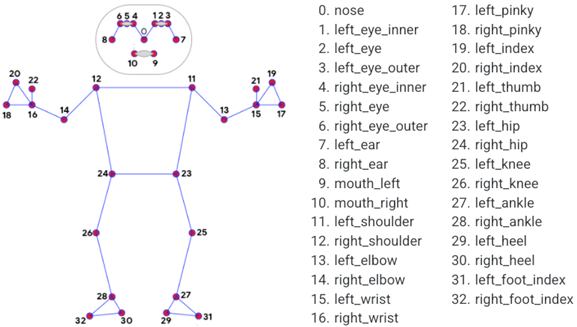
I have selected the following "limbs" to be those that are relevant to a bicep curl:
- Hip to Shoulder
- Elbow to Shoulder
- Wrist to Elbow

These "limbs" are then expressed as unit vectors and the angle between them and the horizontal is found. Then these angles can then be used to find the angular velocity of that angle.

Each frame in the video is expressed as a vector of size 6, the first three elements will be the angles and the remaining three elements will be the corresponding velocities. Also note that all should be scaled.

Then a classification prediction will be made on all frames of a 15fps video.

# Extract Angular Data

I have written three functions in the Functions file (see path above), these functions are:
- detect_Pose(image_pose, pose). This function is only used within the next function.
- extract_angles(path). This function takes the path of the video (must be 30 fps), and returns all four angles mentioned above (in radians).
- moving_average(x, window_size). This takes in the data (x) and the desired size of the moving average window, then just returnes the smoothed version of the input data.

Import the video and process it acquiring the angles, then smooth the data.

In [17]:
path = "C:\\Users\\Cian\\OneDrive\\Documents\\Imperial\\Year 4\\FYP\\Local Download\\Technical\\Bicep Curl Analysis\\Classification\\Training Data (Videos)\\Detailed Exercise Classification\\Testing 9.mp4"
Angles = extract_angles(path)

Perform a moving average on the angle data.

In [18]:
window_size = 7
angles = np.copy(Angles)
angles[:,0], angles[:,1], angles[:,2] = moving_average(Angles[:,0], window_size), moving_average(Angles[:,1], window_size), moving_average(Angles[:,2], window_size)

Plot the angle below as a way of visualizing the data so I can adjust the window size accordingly.

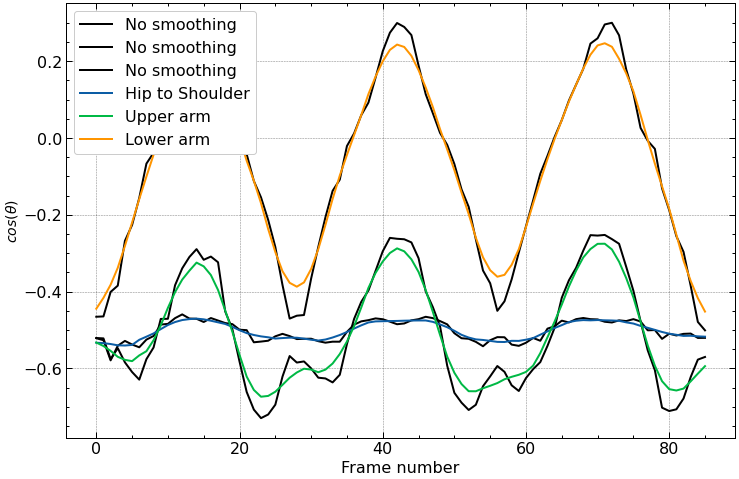

In [19]:
o = np.arange(0,len(angles),1)
plt.figure(figsize=(12,8))
plt.plot(o,Angles[:,0],label='No smoothing',c='black')
plt.plot(o,Angles[:,1],label='No smoothing',c='black')
plt.plot(o,Angles[:,2],label='No smoothing',c='black')
plt.plot(o,angles[:,0],label='Hip to Shoulder')
plt.plot(o,angles[:,1], label='Upper arm')
plt.plot(o,angles[:,2], label = 'Lower arm')
plt.xlabel('Frame number')
plt.ylabel(r'$cos(\theta)$', fontsize = 14)
plt.legend()

# Create Sequences

I won't start at a sequence of length 1 because I suspect this to be too short. Therefore I will start at a sequence of length 15 and then proceed frame by frame making an individual sequence for each frame. Each frame will depend on a sequence of the previous 15 frames.

In [20]:
X = 19
sequences = np.zeros((angles.shape[0]-X+1, X, 3))
for i in range(X,angles.shape[0]+1):
    sequences[i-X] = angles[i-X:i]

# Create Labels

Now create the labels for each frame based on timestamps that I create after watching the video myself.

The timestamps will work as follows:
- List 1 = times at which classes change from one to another.
- List 2 = numbers representing which order the classes are ordered.

In this case the labels will be as follows:
- Not Curl = 0
- Concentric Contraction = 1
- Eccentric Contraction = 2

I will then make a tensor of containing the same number of elements as there are frames in the video. Finally I will change it to a OneHot Encoded form as follows:

### Classes:
- Not Curl = $[1,0,0]$
- Concentric Contraction = $[0,1,0]$
- Eccentric Contraction = $[0,0,1]$

Note that the lists below should be uncommented whenever I am processing the relevent video (I could save these times in a file, however since I am commiting to git it should be fine, I can always revert back to this commit to acquire them if they are deleted).

In [21]:
#This is for the video called "Testing"
# list1 = [0,6.3,7.6,9.25,10.6,12.4,13.9,16.66]
# list2 = [0,1,2,1,2,1,2]
#This is for the video called "Testing 1"
# list1 = [0,1,2,4,5.7,7.2,8.4,10.73,12.05,14.3,16.77,19.31]
# list2 = [0,1,2,1,2,1,2,1,2,1,2]
#This is for the video called "Testing 2"
# list1 = [0,1.4,2.28,3.3,4.27,5.37,6.43,7.78,8.71,10.04,11.2,12.66]
# list2 = [0,1,2,1,2,1,2,1,2,1,2]
#This is for the video called "Testing 3"
# list1 = [0,9.78,10.54,11.8,13.08,15.01,16.54,18.60,19.6,21.28,22.28,24.60]
# list2 = [0,1,2,1,2,1,2,1,2,1,2]
#This is for the video called "Testing 4"
# list1 = [0,9.51,10.38,12.32,13.75,15.67,17.33,19.37,20.82,22.75,24.4,28.14]
# list2 = [0,1,2,1,2,1,2,1,2,1,2]
#This is for the video called "Testing 5"
# list1 = [0,3.7,6.30,10.2,12.68,15.15,17.13,18.66,20.9,22.15,24.45,27.84]
# list2 = [0,1,2,1,2,1,2,1,2,1,2]
#This is for the video called "Testing 6"
# list1 = [0,6.83,8.47,11]
# list2 = [0,1,2]
#This is for the video called "Testing 7"
# list1 = [0,6.20,7.93,10.34,12.22,16]
# list2 = [0,1,2,1,2]
#This is for the video called "Testing 8"
# list1 = [0,1.13,2.5,3.45,4.84,5.96,7.33,8.38,9.53]
# list2 = [1,2,1,2,1,2,1,2]
#This is for the video called "Testing 9"
list1 = [0,0.96,1.94,2.85,3.80,4.77,5.61]
list2 = [1,2,1,2,1,2]

In [22]:
#define the timesteps based on the fps (15 in this case)
dt = 1/15

#Initiallize the labels as an empty array
labels = np.zeros(angles.shape[0])

for i in range(len(list1)-1):
    index0 = round(list1[i]/dt)
    index1 = round(list1[i+1]/dt) + 1
    labels[index0:index1] = int(list2[i])

#Since the sequences start with length X, we need to get rid of the first X labels.
labels = labels[int(X/2):-int(X/2)]

#Now change the labels into categorical form using keras
Labels = to_categorical(labels, 3)

In [23]:
np.save('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 2\\Classification\\Training Data\\W=19, Mid Label\\Data9.npy', sequences)
np.save('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 2\\Classification\\Training Data\\W=19, Mid Label\\Labels9.npy', Labels)

In [12]:
Labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0